# ML Sensitivity Indices

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/QMCSoftware/blob/develop/demos/iris.ipynb)

This notebook demonstrates QMCPy's support for vectorized sensitivity index computation. We preview this functionality by performing classification of Iris species using a decision tree. The computed sensitivity indices provide insight into input subset importance for a classic machine learning problem.

In [1]:
!pip install -q scikit-optimize 

In [2]:
from numpy import *
from qmcpy import *
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from matplotlib import pyplot

## Load Data

We begin by reading in the Iris dataset and providing some basic summary statistics. Our goal will be to predict the Iris class (Setosa, Versicolour, or Virginica) based on Iris attributes (sepal length, sepal width, petal length, and petal width).

In [3]:
data = load_iris()
print(data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [4]:
x = data['data']
y = data['target']
feature_names = data['feature_names']
df = pd.DataFrame(hstack((x,y[:,None])),columns=feature_names+['iris type'])
print('df shape:',df.shape)
target_names = data['target_names']
iris_type_map = {i:target_names[i] for i in range(len(target_names))}
print('iris species map:',iris_type_map)
df.head()

df shape: (150, 5)
iris species map: {0: 'setosa', 1: 'versicolor', 2: 'virginica'}


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),iris type
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [5]:
xt,xv,yt,yv = train_test_split(x,y,test_size=1/3,random_state=7)
print('training data   (xt) shape: %s'%str(xt.shape))
print('training labels (yt) shape: %s'%str(yt.shape))
print('testing data    (xv) shape: %s'%str(xv.shape))
print('testing labels  (yv) shape: %s'%str(yv.shape))

training data   (xt) shape: (100, 4)
training labels (yt) shape: (100,)
testing data    (xv) shape: (50, 4)
testing labels  (yv) shape: (50,)


## Importance of Decision Tree Hyperparameters

We would like to predict Iris species using a Decision Tree (DT) classifier. When initializing a DT, we arrive at the question of how to set hyperparameters such as tree depth or the minimum weight fraction for each leaf. These hyperparameters can greatly effect classification accuracy, so it is worthwhile to consider their importance to determining classification performance.

Note that while this notebook uses decision trees and the Iris dataset, the methodology is directly applicable to other datasets and models. 

We begin this exploration by setting up a hyperparameter domain in which to uniformly sample DT hyperparameter configurations. A helper function and its tie into QMCPy are also created.

In [6]:
hp_domain = [
    {'name':'max_depth', 'bounds':[1,8]},
    {'name':'min_weight_fraction_leaf', 'bounds':[0,.5]}]
hpnames = [param['name'] for param in hp_domain]
hp_lb = array([param['bounds'][0] for param in hp_domain])
hp_ub = array([param['bounds'][1] for param in hp_domain])
d = len(hp_domain)
def get_dt_accuracy(hparams):
    accuracies = zeros(len(hparams))
    for i,hparam in enumerate(hparams):
        kwargs = {hp_domain[j]['name']:hparam[j] for j in range(d)}
        kwargs['max_depth'] = int(kwargs['max_depth'])
        dt = DecisionTreeClassifier(random_state=7,**kwargs).fit(xt,yt)
        yhat = dt.predict(xv)
        accuracies[i] = mean(yhat==yv)
    return accuracies
cf = CustomFun(
    true_measure = Uniform(DigitalNetB2(d,seed=7),lower_bound=hp_lb,upper_bound=hp_ub),
    g = get_dt_accuracy,
    parallel=False)

### Average Accuracy

Our first goal will be to find the average DT accuracy across the hyperparameter domain. To do so, we perform quasi-Monte Carlo numerical integration to approximate the mean testing accuracy.

In [7]:
avg_accuracy,data_avg_accuracy = CubQMCNetG(cf,abs_tol=1e-4).integrate()
data_avg_accuracy

LDTransformData (AccumulateData Object)
    solution        0.787
    comb_bound_low  0.787
    comb_bound_high 0.787
    comb_flags      1
    n_total         2^(14)
    n               2^(14)
    time_integrate  5.305
CubQMCNetG (StoppingCriterion Object)
    abs_tol         1.00e-04
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
CustomFun (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     [1 0]
    upper_bound     [8.  0.5]
DigitalNetB2 (DiscreteDistribution Object)
    d               2^(1)
    dvec            [0 1]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()

Here we find the average accuracy to be 78.7% using $2^{14}$ samples.

### Sensitivity Indices

Next, we wish to quantify how important individual hyperparameters are to determining testing accuracy. To do this, we compute the sensitivity indices of our hyperparameters. In QMCPy we use the `SensitivityIndices` class to compute these sensitivity indices.

In [8]:
si = SensitivityIndices(cf)
solution_importance,data_importance = CubQMCNetG(si,abs_tol=2.5e-2).integrate()
data_importance

LDTransformData (AccumulateData Object)
    solution        [[0.163 0.747]
                    [0.258 0.838]]
    comb_bound_low  [[0.148 0.725]
                    [0.237 0.819]]
    comb_bound_high [[0.178 0.768]
                    [0.278 0.856]]
    comb_flags      [[ True  True]
                    [ True  True]]
    n_total         2^(13)
    n               [[[4096. 8192.]
                     [4096. 8192.]
                     [4096. 8192.]]
                   
                    [[2048. 8192.]
                     [2048. 8192.]
                     [2048. 8192.]]]
    time_integrate  9.214
CubQMCNetG (StoppingCriterion Object)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
SensitivityIndices (Integrand Object)
    indices         [[0]
                    [1]]
    n_multiplier    2^(1)
Uniform (TrueMeasure Object)
    lower_bound     [1 0]
    upper_bound     [8.  0.5]
DigitalNetB2 (DiscreteDistribution Object)
    d      

In [9]:
print('closed sensitivity indices: %s'%str(solution_importance[0].squeeze()))
print('total sensitivity indices: %s'%str(solution_importance[1].squeeze()))

closed sensitivity indices: [0.16294073 0.74680538]
total sensitivity indices: [0.2577826  0.83777583]


Looking closer at the output, we see that the second hyperparameter (`min_weight_fraction_leaf`) is more important than the first one (`max_depth`). The closed sensitivity indices measure how much that hyperparameter contributes to testing accuracy variance. The total sensitivity indices measure how much that hyperparameter, or any subset of hyperparameters containing that one contributes to testing accuracy variance. For example, the first closed sensitivity index approximates the variability attributable to {`max_depth`} while the first total sensitivity index approximates the variability attributable to both {`max_depth`} and {`max_depth`,`min_weight_fraction_leaf`}.  

### Marginals

We may also use QMCPy's support for vectorized quasi-Monte Carlo to compute marginal distributions. This is relatively straightforward to do for the Uniform true measure used here, but caution should be taken when adapting these techniques to distributions without independent marginals.

In [10]:
def marginal(x,compute_flags,xpts,bools,not_bools):
    n,_ = x.shape
    x2 = zeros((n,d),dtype=float)
    x2[:,bools] = x
    y = zeros((n,len(xpts)),dtype=float)
    for k,xpt in enumerate(xpts):
        if not compute_flags[k]: continue
        x2[:,not_bools] = xpt
        y[:,k] = get_dt_accuracy(x2)
    return y

Text(0.5, 0, 'max depth')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'min weight fraction leaf')

Text(0, 0.5, 'accuracy')

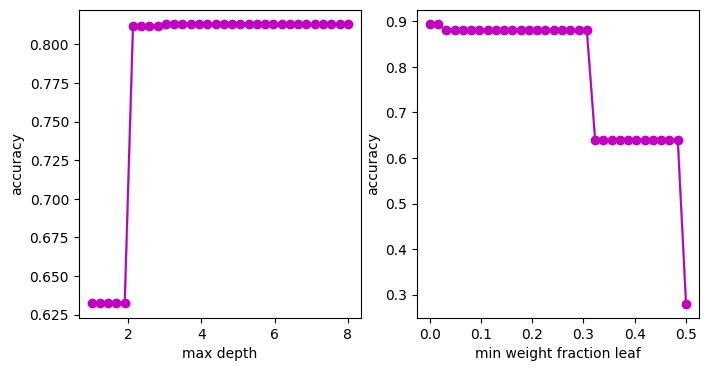

In [11]:
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(8,4));
nticks = 32
xpts01 = linspace(0,1,nticks)
for i in range(2):
    xpts = xpts01*(hp_ub[i]-hp_lb[i])+hp_lb[i]
    bools = array([True if j not in [i] else False for j in range(d)])
    def marginal_i(x,compute_flags): return marginal(x,compute_flags,xpts,bools,~bools)
    cf = CustomFun(
         true_measure = Uniform(DigitalNetB2(1,seed=7),lower_bound=hp_lb[bools],upper_bound=hp_ub[bools]),
         g = marginal_i,
         dimension_indv = len(xpts),
         parallel=False)
    sol,data = CubQMCNetG(cf,abs_tol=5e-2).integrate()
    ax[i].plot(xpts,sol,'-o',color='m');
    ax[i].fill_between(xpts,data.comb_bound_high,data.comb_bound_low,color='c',alpha=.5);
    ax[i].set_xlabel(hpnames[i].replace('_',' '));
    ax[i].set_ylabel('accuracy');

## Bayesian Optimization of Hyperparameters

Having explored DT hyperparameter importance, we are now ready to construct our optimal DT. We already have quite a bit of data relating hyperparameter settings to testing accuracy, so we may simply select the best configuration and call this an optimal DT. However, if we are looking to squeeze out even more performance, we may choose to perform Bayesian Optimization which incorporates our past metadata. Sample code is provided below despite not finding an improved configuration for this problem.

In [12]:
x0 = data_avg_accuracy.xfull*(hp_ub-hp_lb)+hp_lb
y0 = -data_avg_accuracy.yfull.squeeze()
print('best result before BO is %d%% accuracy'%(-100*y0.min()))
result = gp_minimize(
    func = lambda hparams: get_dt_accuracy(atleast_2d(hparams)).squeeze().item(),
    dimensions = [(l,u) for l,u in zip(hp_lb,hp_ub)],
    n_calls = 32,
    n_initial_points = 0,
    x0 = x0[:128].tolist(),
    y0 = y0[:128].tolist(),
    random_state = 7)
xbo_best = result.x
ybo_best = -result.fun
print('best result from BO is %d%% accuracy'%(100*ybo_best))
xbo = array(result.x_iters)
ybo = -array(result.func_vals)

best result before BO is 94% accuracy
best result from BO is 94% accuracy
best result from BO is 94% accuracy


## Best Decision Tree Analysis

Below we print the configuration that rested in the best DT. We also print the optimal accuracy achieved (at this configuration) and visualize the branches of this tree. 

{'max_depth': 4, 'min_weight_fraction_leaf': 0.010670859601136062}
best decision tree accuracy: 94.0%


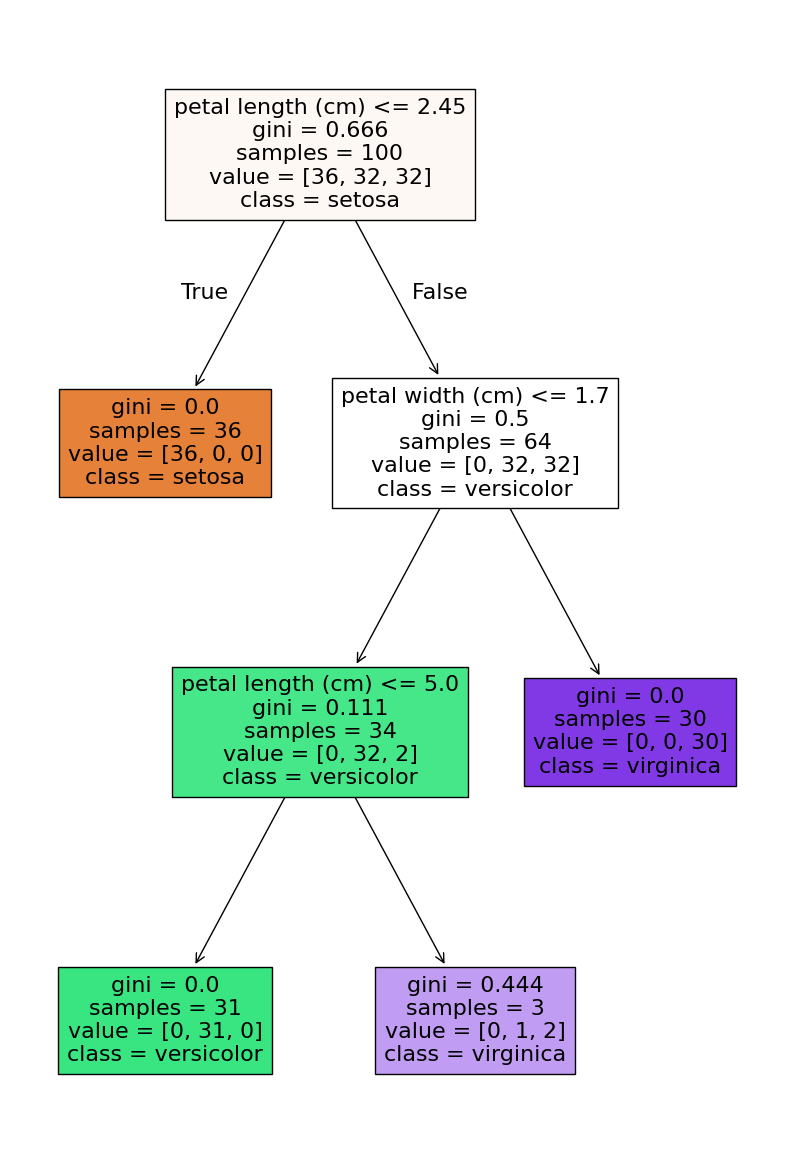

In [13]:
best_kwargs = {name:val for name,val in zip(hpnames,xbo_best)}
best_kwargs['max_depth'] = int(best_kwargs['max_depth'])
print(best_kwargs)
dt = DecisionTreeClassifier(random_state=7,**best_kwargs).fit(xt,yt)
yhat = dt.predict(xv)
accuracy = mean(yhat==yv)
print('best decision tree accuracy: %.1f%%'%(100*accuracy))
fig = pyplot.figure(figsize=(10,15))
plot_tree(dt,feature_names=feature_names,class_names=target_names,filled=True);

### Feature Importance

With the optimal DT in hand, we may now question how important the Irises features are in determining the class/species. To answer this question, we again perform sensitivity analysis, but this time we select a uniform measure over the domain of Iris features. Our output which we wish to quantify the variance of is now a length 3 vector of class probabilities. How variable is each species classification as a function of each Iris feature?

In [14]:
xfeatures = df.to_numpy()
xfeatures_low = xfeatures[:,:-1].min(0)
xfeatures_high = xfeatures[:,:-1].max(0)
d_features = len(xfeatures_low)
def dt_pp(t,compute_flags): return dt.predict_proba(t)
cf = CustomFun(
    true_measure = Uniform(DigitalNetB2(d_features,seed=7),
        lower_bound = xfeatures_low,
        upper_bound = xfeatures_high),
    g = dt_pp,
    dimension_indv = 3,
    parallel = False)
indices = [[0],[1],[2],[3],[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[1,2,3],[0,2,3],[0,1,2]]
si_cf = SobolIndices(cf,indices)
solution,data = CubQMCNetG(si_cf,abs_tol=1e-3,n_init=2**10).integrate()
data

/Users/terrya/Documents/ProgramData/QMCSoftware/qmcpy/util/abstraction_functions.py:36


LDTransformData (AccumulateData Object)
    solution        [[[0.    0.    0.   ]
                     [0.    0.    0.   ]
                     [0.999 0.43  0.456]
                     ...
                     [0.999 0.999 0.999]
                     [0.999 0.999 0.999]
                     [0.999 0.43  0.456]]
                   
                    [[0.    0.    0.   ]
                     [0.    0.    0.   ]
                     [0.999 0.646 0.662]
                     ...
                     [0.999 0.999 0.999]
                     [0.999 0.999 0.999]
                     [0.999 0.646 0.662]]]
    comb_bound_low  [[[0.    0.    0.   ]
                     [0.    0.    0.   ]
                     [0.999 0.43  0.455]
                     ...
                     [0.999 0.999 0.998]
                     [0.999 0.999 0.998]
                     [0.999 0.43  0.455]]
                   
                    [[0.    0.    0.   ]
                     [0.    0.    0.   ]
                   

While the solution looks unwieldy, it has quite a natural interpretation. The first axis determines whether we are looking at a closed (index 0) or total (index 1) sensitivity index as before. The second axis indexes the subset of features we are testing. The third and final axis is length 3 for the 3 class probabilities we are interested in. For example, `solution[0,2,2]` looks at the closed sensitivity index of our index 2 feature (petal length) for our index 2 probability (virginica) AKA how important is petal length alone to determining if an Iris is virginica.

The results indicate that setosa Irises can be completely determined based on petal length while the versicolor and virginica Irises can be completely determined by looking at both petal length and petal width. Interestingly sepal length and sepal width do not contribute significantly to determining species. 

These insights are not surprising or especially insightful for a decision tree where the tree structure indicates importance and the scores may even be computed directly. However, for more complicated models and datasets, this analysis pipeline may provide advanced insight into both hyperparameter tuning and feature importance. 

In [ ]:
print('solution shape:',solution.shape,'\n')
si_closed = solution[0]
si_total = solution[1]
print('SI Closed')
print(si_closed,'\n')
print('SI Total')
print(si_total)

solution shape: (2, 13, 3) 

SI Closed
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.99943242 0.43046351 0.45620515]
 [0.         0.35361725 0.33838253]
 [0.         0.         0.        ]
 [0.99943242 0.43046351 0.45620515]
 [0.         0.35361725 0.33838253]
 [0.99943242 0.43046351 0.45620515]
 [0.         0.35361725 0.33838253]
 [0.99943242 0.9994106  0.99907653]
 [0.99943242 0.9994106  0.99907653]
 [0.99943242 0.9994106  0.99907653]
 [0.99943242 0.43046351 0.45620515]] 

SI Total
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.99948887 0.6456608  0.66155867]
 [0.         0.56952443 0.54400218]
 [0.         0.         0.        ]
 [0.99948887 0.6456608  0.66155867]
 [0.         0.56952443 0.54400218]
 [0.99948887 0.6456608  0.66155867]
 [0.         0.56952443 0.54400218]
 [0.99948887 0.99915912 0.99921556]
 [0.99948887 0.99915912 0.99921556]
 [0.99948887 0.99915912 0.99921556]
 [0.99948887 0.6456608  0.66155867]]


: 